CPU
['CPUExecutionProvider']
CUDAExecutionProvider not available. Using CPU.
im shape: (512, 512, 3) , im dtype: uint8 
image shape: (512, 512, 3)
image shape: (512, 512, 3)
Time to encode: 0.04201531410217285
Encoded shape: (262144, 5)
min cm_new: 0.0, max cm_new: 0.4596594572067261
min bm_new: -0.16603510081768036, max bm_new: 2.5132036209106445
min cm_new: 0.05000000074505806, max cm_new: 2.6766254901885986
min bm_new: -0.16103510558605194, max bm_new: 2.5182037353515625
min cm_new: 0.10000000149011612, max cm_new: 4.039938449859619
min bm_new: -0.15603509545326233, max bm_new: 2.5232036113739014


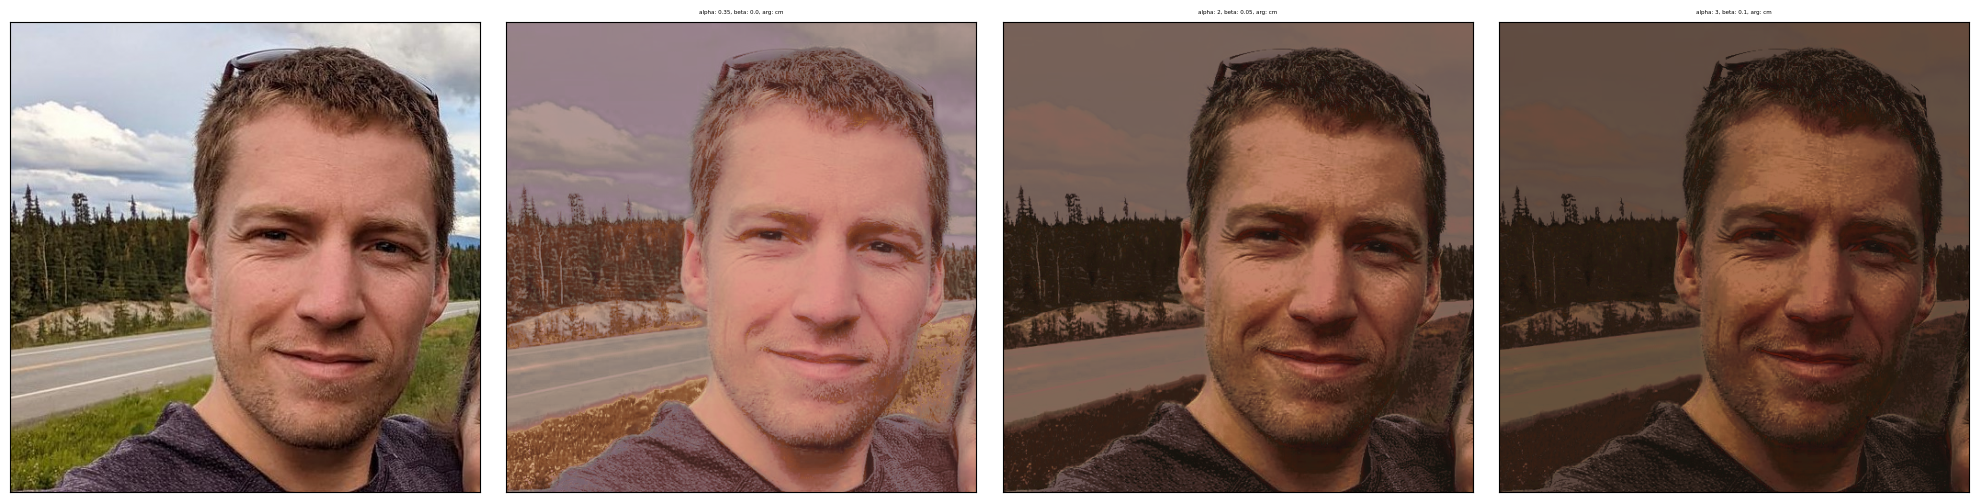

min ch_new: -0.20643064379692078, max ch_new: 0.43591317534446716
min bh_new: 0.4355755150318146, max bh_new: 1.0989412069320679
min ch_new: -1.1296037435531616, max ch_new: 2.5409324169158936
min bh_new: 0.48557552695274353, max bh_new: 1.148941159248352
min ch_new: -1.6694055795669556, max ch_new: 3.8363986015319824
min bh_new: 0.585575520992279, max bh_new: 1.24894118309021


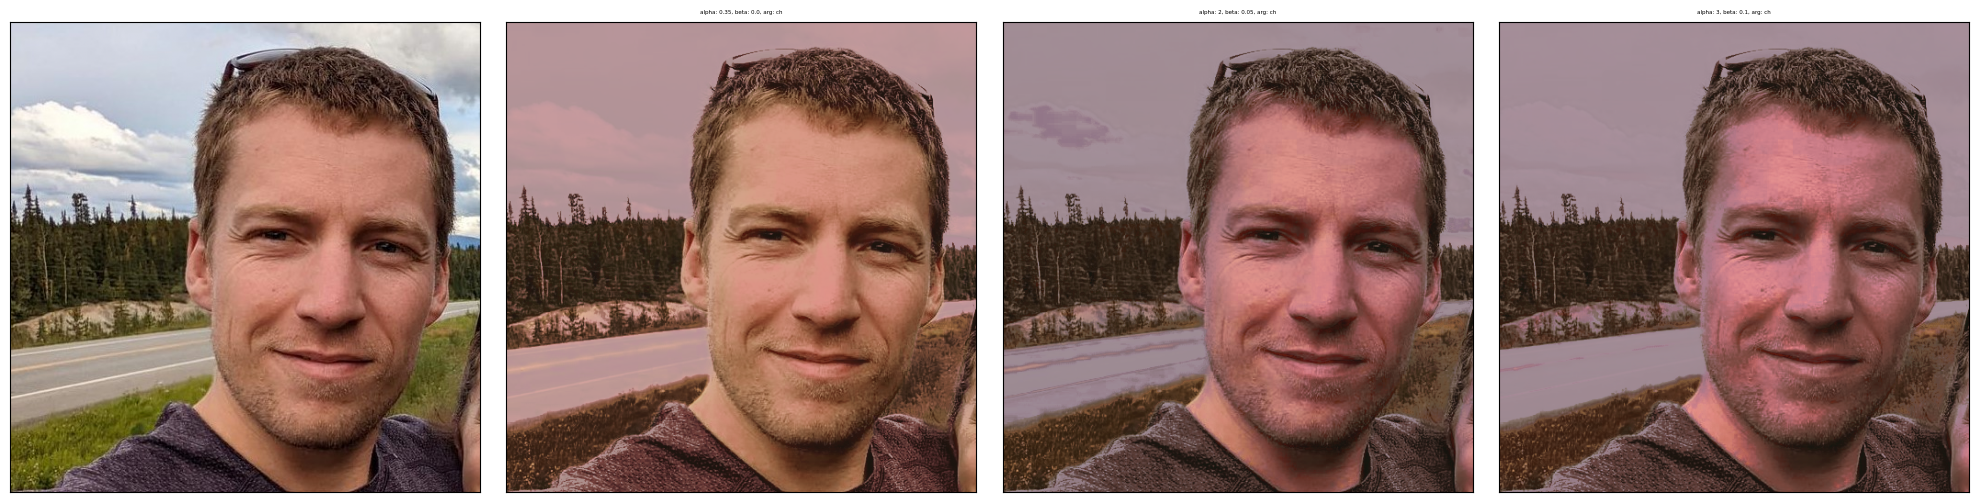

In [9]:
import numpy as np
import onnxruntime as ort
print(ort.get_device())
print(ort.get_available_providers())
import onnx_inference
from onnx_inference import onnx_ae 
import os
# from PIL import Image
import sys
import torch
import os
import os.path as osp
import numpy as np
import time
from PIL import Image
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
import pickle
import importlib
import torch_face
from torch_face import face_part_segmentation as fps
sys.path.append("segmentation")
import segmentation as seg
importlib.reload(seg)


def increase_values(encoded, alpha=1.0, beta=0.1):
    """
    Increases the values in the latent space representation.

    :param encoded: The latent space representation.
    :param alpha: Scale factor for the increase.
    :param beta: Bias for the increase.
    :return: Modified latent space representation.
    """
    return encoded * alpha + beta

def modify_latent_space_for_skin(encoded_data, mask, modification_function, *args, **kwargs):
    """
    Modifies the latent space representation for skin areas in the image.

    :param encoded_data: Encoded representation of the image (latent space).
    :param mask: A binary mask indicating skin areas (1 for skin, 0 for non-skin).
    :param modification_function: A function that modifies the latent space representation.
    :param args: Additional arguments for the modification function.
    :param kwargs: Additional keyword arguments for the modification function.
    :return: Modified latent space representation.
    """
    max_value = np.max(encoded_data)
    min_value = np.min(encoded_data)
    mask = np.asarray(mask)
    mask = cv2.resize(mask, (WIDTH, HEIGHT), interpolation=cv2.INTER_LANCZOS4)
    if mask.ndim == 3:
        mask = mask[:, :, 0]  # Assume the mask is the same for all channels
    # Ensure the mask is binary and match the shape of the latent space
    mask = mask.reshape(encoded_data.shape)
    mask = np.where(mask > 0, 1, 0)

    # Apply modification to the skin areas in latent space
    modified_encoded = modification_function(encoded_data, *args, **kwargs)

    # Combine the modified areas with the original latent space using the mask
    combined_encoded = np.where(mask == 1, modified_encoded, encoded_data)

    return combined_encoded

encoder_path = r"C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\onnx_inference\small_batch_size_encoder.onnx"
decoder_path = r"C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\onnx_inference\small_batch_size_decoder.onnx"
ae = onnx_ae.ONNXAutoencoder(encoder_path, decoder_path)
image_path = r"C:\Desktop\joel.jpg"
im = cv2.imread(image_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im_224 = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LANCZOS4)
WIDTH, HEIGHT = 512, 512
segmenter = fps.FacePartSegmentation()

# im reshape to 224x224

#save im_224 rgb
im_224_rgb = cv2.cvtColor(im_224, cv2.COLOR_BGR2RGB)
cv2.imwrite("im_224_rgb.jpg", im_224_rgb)
if np.array(im).shape[0] < 512 or np.array(im).shape[1] < 512:
    im = cv2.resize(im, (WIDTH, HEIGHT), interpolation=cv2.INTER_LANCZOS4)
print(f"im shape: {im.shape} , im dtype: {im.dtype} ")
skin = segmenter.get_skin(im)
combined_mask, face, av_skin_color = seg.create_combined_mask(im)
face = cv2.resize(face, (WIDTH, HEIGHT), interpolation=cv2.INTER_LANCZOS4)

face = cv2.resize(face, (WIDTH, HEIGHT), interpolation=cv2.INTER_LANCZOS4)

if np.max(im) > 1.0:
    im = im / 255.0
start = time.time()
encoded = ae.encode(np.asarray(im).astype(np.float32).reshape(-1, 3))
end = time.time()
print(f"Time to encode: {end-start}")
encoded = np.asarray(encoded).astype(np.float32).reshape(-1, 5)
print(f"Encoded shape: {encoded.shape}")
pm = np.asarray(encoded).astype(np.float32).reshape(WIDTH, HEIGHT, 5)
cm = pm[:,:,0]
ch = pm[:,:,1]
bm = pm[:,:,2]
bh = pm[:,:,3]
t = pm[:,:,4]
# alphas = np.linspace(0.1, 3.0, 5)
alphas = [ 0.35, 2, 3]
alphasBm = [0.75, 1.0, 1.25]
alphasCh = [0.25, 2.0, 4.0]
alphasBh = [0.85, 1.0, 1.5]
betas = [0.0, 0.05, 0.1, 0.15]
betasCh = [0.0, 0.01, 0.02]
betasBh = [0.0, 0.1, 0.2]
betasBm = [0.0, 0.005, 0.01, 0.015]
#append 1 to the end of the listss

args = ['cm', 'ch']

for arg in args:
    fig1, ax1 = plt.subplots(1,1+ len(alphas), figsize=(20, 5))
    ax1[0].imshow(im)
    ax1_index = 1
    for i, alpha in enumerate(alphas):
        beta = betas[i]
        pm = None
        gamma = 0 #gamma is not used
        if arg == 'cm':
            # print(f"Modifying cm with alpha: {alpha} and beta: {beta}")
            # cm_new = modify_latent_space_for_skin(cm, skin, increase_values, alpha, beta)
            alpha = alphas[i]
            beta = betas[i]
            #remove negative values
            cm = np.where(cm < 0, 0, cm)
            cm_new = cm*(alpha) + beta
            if i == 0:
                bm_new = bm
            else:
                bm_new = bm+betasBm[i]
            print(f"min cm_new: {np.min(cm_new)}, max cm_new: {np.max(cm_new)}")
            print(f"min bm_new: {np.min(bm_new)}, max bm_new: {np.max(bm_new)}")
            t_new = t+0.1
            pm = np.dstack((cm_new, ch, bm_new, bh, t))
            gamma = cm_new
        if arg == 'ch':
            # print(f"Modifying ch with alpha: {alpha} and beta: {beta}")
            ch_new = ch * alpha + beta
            
            if i == 0:
                bh_new = bh
            else:
                bh_new += beta
            t = np.where(t < 0, 0, t)
            
            pm = np.dstack((cm, ch_new, bm, bh_new, t))
            print(f"min ch_new: {np.min(ch_new)}, max ch_new: {np.max(ch_new)}")
            print(f"min bh_new: {np.min(bh_new)}, max bh_new: {np.max(bh_new)}")
            gamma = ch_new
        if arg == 'bm':
            # print(f"Modifying bm with alpha: {alpha} and beta: {beta}")
            bm_new = modify_latent_space_for_skin(bm, skin, increase_values, alpha, beta)
            pm = np.dstack((cm, ch, bm_new, bh, t))
        if arg == 'bh':
            # print(f"Modifying bh with alpha: {alpha} and beta: {beta}")
            bh_new = modify_latent_space_for_skin(bh, skin, increase_values, alpha, beta)
            pm = np.dstack((cm, ch, bm, bh_new, t))
        if arg == 't':
            # print(f"Modifying t with alpha: {alpha} and beta: {beta}")
            t_new = modify_latent_space_for_skin(t, skin, increase_values, alpha, beta)
            pm = np.dstack((cm, ch, bm, bh, t_new))
        #clip values
        pm = np.clip(pm, 0.0, 1.0)
        encoded = np.asarray(pm).astype(np.float32)
        encoded = encoded.reshape(-1, 5)
        start = time.time()
        decoded = ae.decode(encoded)
        end = time.time()
        decoded = np.asarray(decoded).astype(np.float32).reshape(WIDTH, HEIGHT, 3)
        # print(f"Time to decode: {end-start}, decoded shape: {decoded.shape}, decoded dtype: {decoded.dtype}")

        if np.max(decoded) < 1.0:
            decoded = decoded * 255.0
        if np.max(im) < 1.0:
            im = im * 255.0
        im = im.reshape(WIDTH, HEIGHT, 3)
        decoded = decoded.astype(np.float32).reshape(WIDTH, HEIGHT, 3)
        if np.max(face) > 2:
            face = face / 255.0
        if np.max(im) >2:
            im = im / 255.0
        if np.max(decoded) >2:
            decoded = decoded / 255.0
  

        ax1 = ax1.flatten()
        for axi in ax1:
            axi.set_xticks([])
            axi.set_yticks([])

        ax1[ax1_index].imshow(decoded)
        ax1[ax1_index].set_title(f"alpha: {alpha}, beta: {beta}, arg: {arg}", fontsize=4)
        #no axis ticks
        ax1[ax1_index].set_xticks([])
        ax1[ax1_index].set_yticks([])
        #no axis labels
        ax1[ax1_index].set_xlabel("")
        ax1[ax1_index].set_ylabel("")
        ax1_index += 1

    plt.tight_layout()
    plt.show()


In [13]:
from dense_lm import segmentation as seg
from dense_lm import morph as morph


morphing C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\fitzpatrick\m32_4k.png to C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\fitzpatrick\ft_2_ft_2_053426.png


c:\Users\joeli\miniforge3\envs\torch_311\Lib\site-packages\google\protobuf\symbol_database.py:78: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


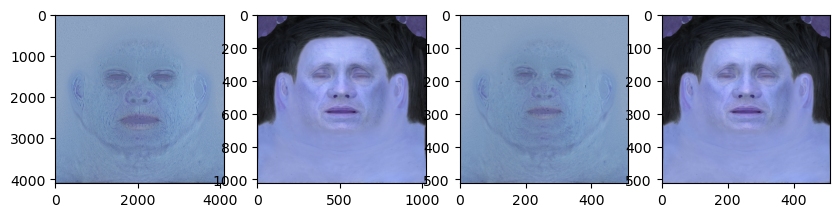

parameter_maps.shape: (262144, 5)
image shape: (512, 512, 3)
image shape: (512, 512, 3)


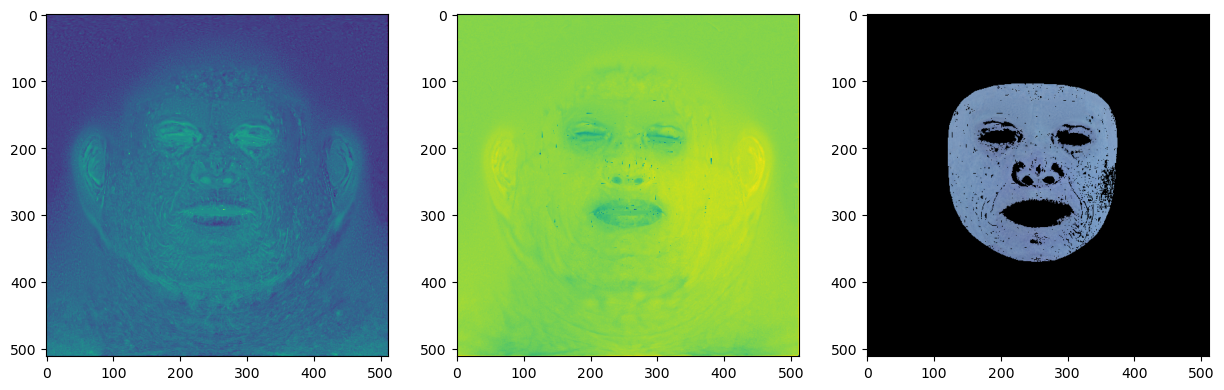

In [19]:

example_texture_path = r"C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\fitzpatrick\m32_4k.png"
target_texture_path = r"C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\fitzpatrick\ft_2_ft_2_053426.png"
width = 512
height = 512
warped_example_image, original_image = morph.morph_images(example_texture_path, target_texture_path, width, height)
example_image = cv2.imread(example_texture_path)
target_image = cv2.imread(target_texture_path)
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0].imshow(example_image)
ax[1].imshow(target_image)
ax[2].imshow(warped_example_image)
ax[3].imshow(original_image)
plt.show()
Cm, Ch, Bm, Bh, T, skin = seg.extract_masks(warped_example_image)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(Cm)
ax[1].imshow(Bh)
ax[2].imshow(skin)
plt.show()

mel_aged = Cm
oxy_aged = Bh
skin = skin